In [1]:
import warnings
warnings.filterwarnings('ignore')
from ucimlrepo import fetch_ucirepo
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

In [2]:
class DataFeaturesImportances:
    def __init__(self, x: pd.DataFrame, y: pd.Series, seed: int = 42):
        self.x = x
        self.y = y
        self.seed = seed
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            x, y, test_size=0.2, random_state=seed
        )

    def get_matrix_corr(self) -> pd.DataFrame:
        df = self.x.copy()
        df['target'] = self.y
        corr_matrix = df.corr()
        return corr_matrix['target']

    # RandomForestRegressor
    def get_random_forest_regressor_feature_importance(self) -> pd.DataFrame:
        X = self.x.copy()
        X_train = self.X_train.copy()
        y_train = self.y_train.copy()
        seed = self.seed
        # Entrenar el modelo
        reg = RandomForestRegressor(n_estimators=100, random_state=seed)
        reg.fit(X_train, y_train)
        # Calcular la importancia de las características
        importances = reg.feature_importances_
        feature_names = X.columns

        # Crear un DataFrame de la importancia de las características
        feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
        return feature_importance_df

    # RandomForestRegressor with Permutation
    def get_random_forest_regressor_permutation_feature_importance(self) -> pd.DataFrame:
        X = self.x.copy()
        X_train = self.X_train.copy()
        X_test = self.X_test.copy()
        y_train = self.y_train.copy()
        y_test = self.y_test.copy()
        seed = self.seed
        reg = RandomForestRegressor(n_estimators=100, random_state=seed)
        reg.fit(X_train, y_train)
        # Calcular la importancia de las características basada en permutación
        result = permutation_importance(reg, X_test, y_test, n_repeats=10, random_state=seed)

        # Crear un DataFrame de la importancia de las características
        importances = result.importances_mean
        feature_names = X.columns
        feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
        return feature_importance_df

    def get_lasso_linear_regression_feature_importance(self) -> pd.DataFrame:
        # Normalizar los datos
        X = self.x.copy()
        y = self.y.copy()
        seed = self.seed
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

        # Crear el modelo Lasso con validación cruzada
        lasso_cv = LassoCV(alphas=np.logspace(-4, 4, 100), cv=5)
        # Ajustar el modelo
        lasso_cv.fit(X_train, y_train)

        # Entrenar el modelo Lasso
        lasso = Lasso(alpha=lasso_cv.alpha_)
        lasso.fit(X_train, y_train)

        # Obtener los coeficientes del modelo
        importances = lasso.coef_
        feature_names = X.columns

        # Crear un DataFrame de la importancia de las características
        feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
        return feature_importance_df

    def get_xgboost_feature_importance(self):
        X = self.x.copy()
        X_train = self.X_train.copy()
        y_train = self.y_train.copy()
        seed = self.seed
        # Entrenar el modelo XGBoost
        # xgb = XGBRegressor(random_state=seed)
        xgb = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
        xgb.fit(X_train, y_train)

        # Obtener la importancia de las características
        importances = xgb.feature_importances_
        feature_names = X.columns

        # Crear un DataFrame de la importancia de las características
        feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
        return feature_importance_df

    def get_feature_importance_matrix(self) -> pd.DataFrame:
        rf_importance = self.get_random_forest_regressor_feature_importance()
        rf_permutation_importance = self.get_random_forest_regressor_permutation_feature_importance()
        lasso_importance = self.get_lasso_linear_regression_feature_importance()
        xgboost_importance = self.get_xgboost_feature_importance()

        importance_matrix = pd.DataFrame({
            'Feature': self.x.columns,
            'Random Forest': rf_importance.set_index('Feature').reindex(self.x.columns)['Importance'].values,
            'RF Permutation': rf_permutation_importance.set_index('Feature').reindex(self.x.columns)['Importance'].values,
            'Lasso': lasso_importance.set_index('Feature').reindex(self.x.columns)['Importance'].values,
            'XGBoost': xgboost_importance.set_index('Feature').reindex(self.x.columns)['Importance'].values,
        })
        return importance_matrix


In [3]:
df = pd.read_parquet('steel-dataset.parquet')

In [4]:
y = df['Usage_kWh']
X = df.drop(['Usage_kWh'], axis=1)

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_ = pd.DataFrame(X_scaled, columns=X.columns)

In [6]:
dataset_filename = Path('./steel_industry_energy_consumption_clean_features_importances.parquet')
if dataset_filename.exists():
    df_features_importances = pd.read_parquet(dataset_filename)
else:
    data = DataFeaturesImportances(X, y)
    df_features_importances = data.get_feature_importance_matrix()
    df_features_importances.to_parquet('steel_industry_energy_consumption_clean_features_importances.parquet')

In [7]:
df_features_importances

,Feature,Random Forest,RF Permutation,Lasso,XGBoost
0,Lagging_Current_Reactive.Power_kVarh,0.015708,1.053330e+00,0.330029,0.011051
1,Leading_Current_Reactive_Power_kVarh,0.000425,2.027591e-03,0.070686,0.001115
2,CO2(tCO2),0.975624,9.453431e-01,1639.920684,0.970738
3,Lagging_Current_Power_Factor,0.005090,3.801236e-02,0.123032,0.002280
4,Leading_Current_Power_Factor,0.001327,8.250609e-03,0.061235,0.004219
5,NSM,0.001247,2.958723e-02,-0.000003,0.002049
6,Day_of_week_Friday,0.000021,5.267871e-07,-0.019410,0.000106
7,Day_of_week_Monday,0.000024,2.345855e-06,-0.000002,0.000076
8,Day_of_week_Saturday,0.000015,2.836479e-05,0.000000,0.000181
9,Day_of_week_Sunday,0.000009,8.874928e-06,0.294537,0.000305


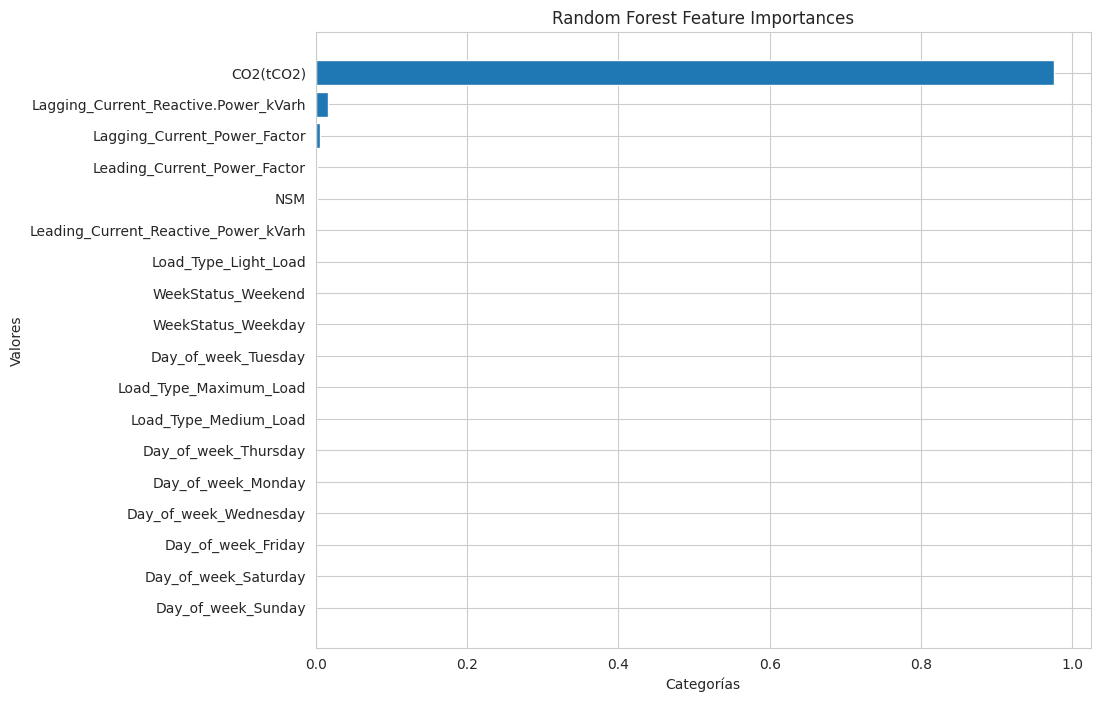

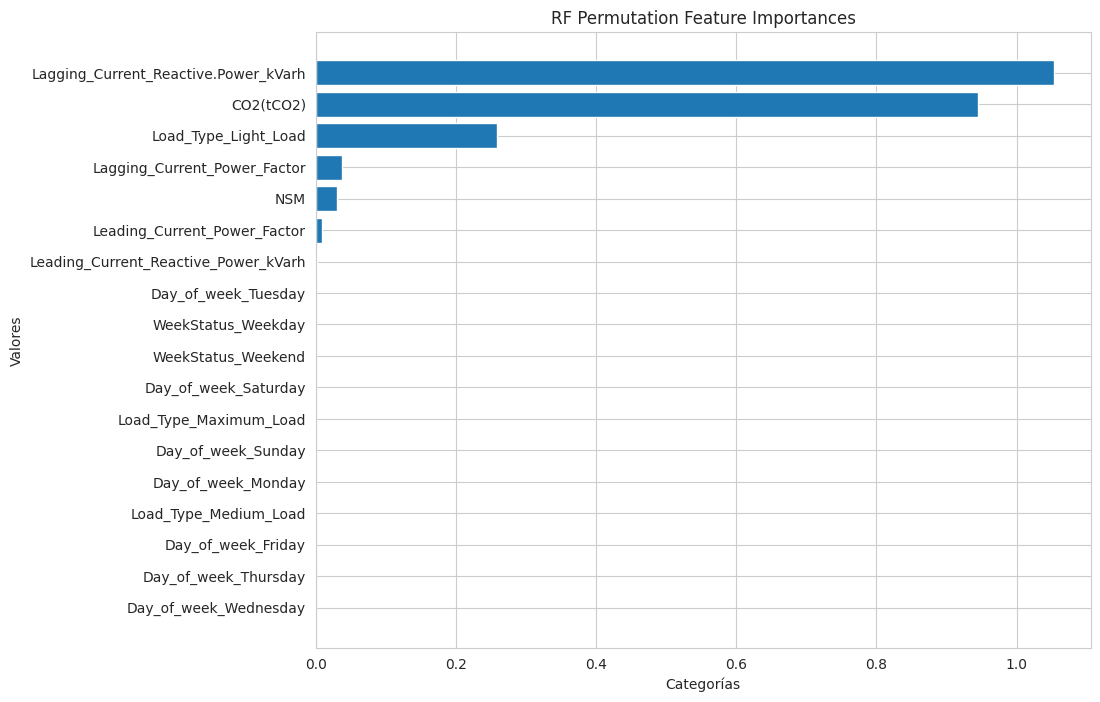

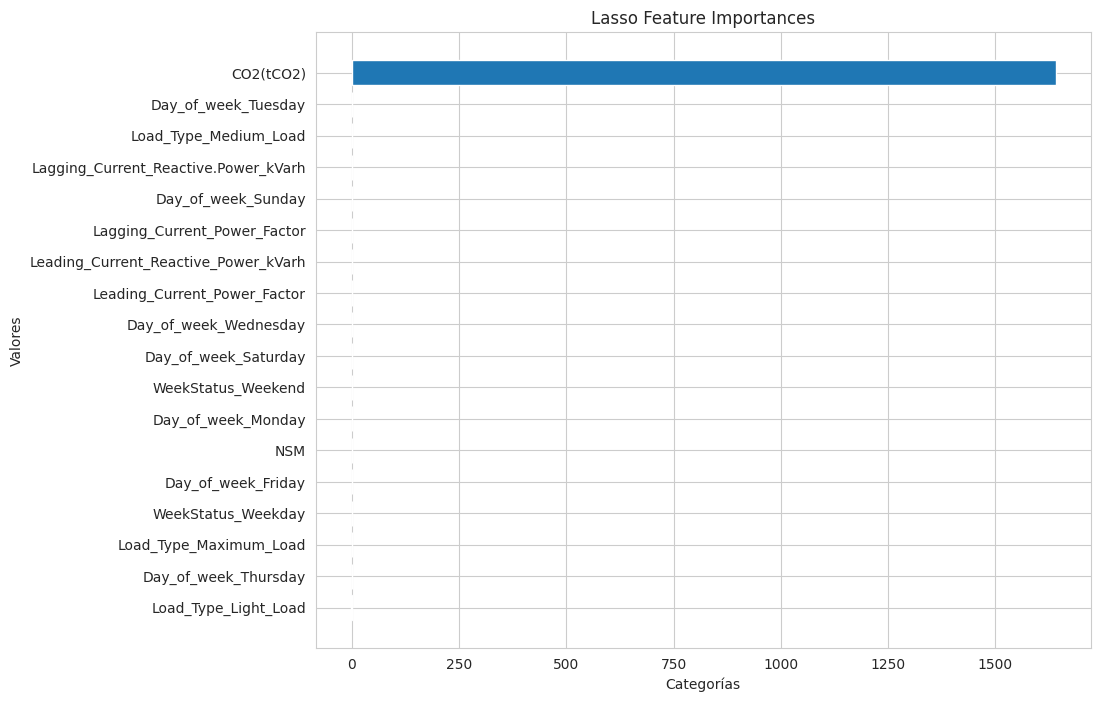

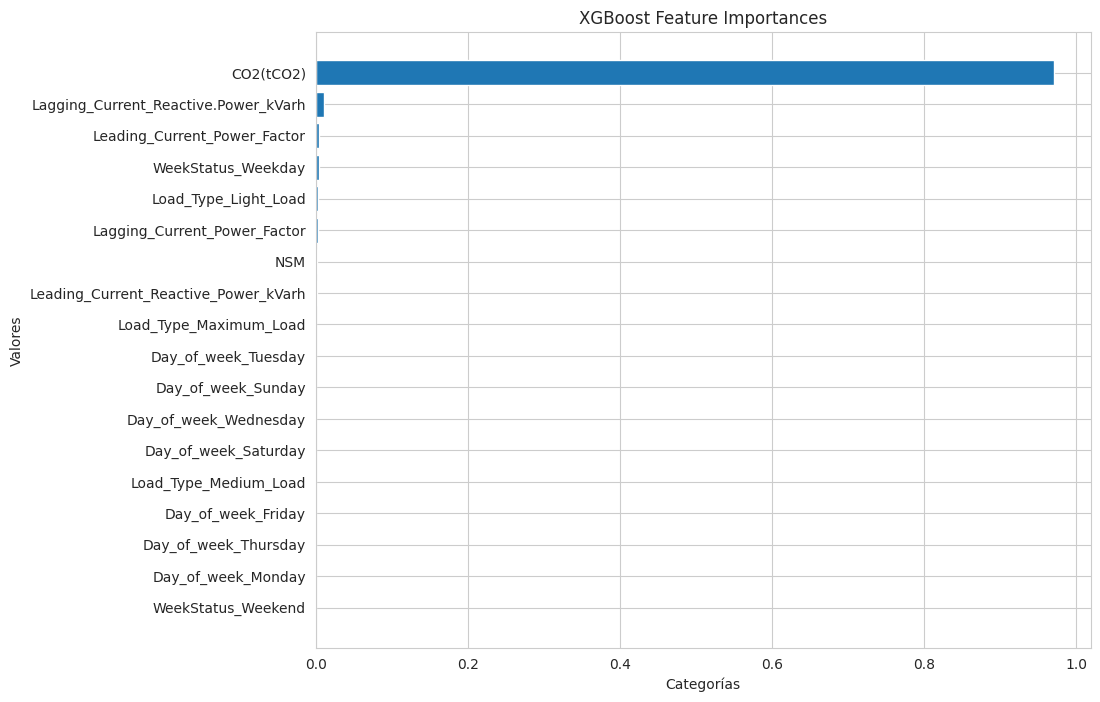

In [8]:
for feature_model in df_features_importances.columns[1:]:
    df_features_importances.sort_values(by=[feature_model], ascending=True, inplace=True)
    
    plt.figure(figsize=(10, 8))
    plt.barh(df_features_importances['Feature'], df_features_importances[feature_model])
    # Títulos y etiquetas
    plt.title(f"{feature_model} Feature Importances")
    plt.xlabel("Categorías")
    plt.ylabel("Valores")
    
    # plt.xlim(0, 0.02)  # Para visualizar los más pequeños
    #plt.ylim(0, 1) # Para visualizar los más pequeños
    # Inclinar texto en el eje X
    plt.xticks(rotation=0)

    # Mostrar gráfico
    plt.show()

## Los campos "Day_of_week" y "WeekStatus" no aportan información relevante al modelo. Podrían ser eliminados.

### Data para trabajar permanece sin cambios, solo sin campo "date" y los campos con valores categóricos con OHE

In [9]:
df = pd.read_parquet('steel-dataset.parquet')

In [10]:
df

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,Day_of_week_Friday,Day_of_week_Monday,Day_of_week_Saturday,Day_of_week_Sunday,Day_of_week_Thursday,Day_of_week_Tuesday,Day_of_week_Wednesday,Load_Type_Light_Load,Load_Type_Maximum_Load,Load_Type_Medium_Load,WeekStatus_Weekday,WeekStatus_Weekend
0,3.17,2.95,0.00,0.0,73.21,100.00,900,False,True,False,False,False,False,False,True,False,False,True,False
1,4.00,4.46,0.00,0.0,66.77,100.00,1800,False,True,False,False,False,False,False,True,False,False,True,False
2,3.24,3.28,0.00,0.0,70.28,100.00,2700,False,True,False,False,False,False,False,True,False,False,True,False
3,3.31,3.56,0.00,0.0,68.09,100.00,3600,False,True,False,False,False,False,False,True,False,False,True,False
4,3.82,4.50,0.00,0.0,64.72,100.00,4500,False,True,False,False,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,3.85,4.86,0.00,0.0,62.10,100.00,82800,False,True,False,False,False,False,False,True,False,False,True,False
35036,3.74,3.74,0.00,0.0,70.71,100.00,83700,False,True,False,False,False,False,False,True,False,False,True,False
35037,3.78,3.17,0.07,0.0,76.62,99.98,84600,False,True,False,False,False,False,False,True,False,False,True,False
35038,3.78,3.06,0.11,0.0,77.72,99.96,85500,False,True,False,False,False,False,False,True,False,False,True,False
